In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42
lr = 0.0001
batch = 16

In [4]:
X_train, y_train, X_test, y_test, X_val, y_val, vocab_size, emdedding_size, vectors = get_data()

In [5]:
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))
print('Val labels: ', collections.Counter(y_val))

Train labels:  Counter({1: 3021, 0: 3020})
Test labels:  Counter({0: 863, 1: 863})
Val labels:  Counter({0: 432, 1: 431})


In [6]:
train_max = X_train.max()
test_max = X_test.max()
val_max = X_val.max()
max_all = max([train_max, test_max, val_max])
input_dim = max_all+1
output_dim = 32

In [7]:
# Concatinate train and validation to be used in cross validation
Xtrain_concat = np.concatenate((X_train,X_val),axis=0)
ytrain_concat = np.concatenate((y_train,y_val),axis=0)

In [8]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='min')

In [10]:
adamOptimizer = Adam(lr=lr)

In [11]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title, modelname):
    pp = PdfPages(modelname)
    plt.figure()
    history = history_arrs[0]
    plt.plot(history[train])
    plt.plot(history[val])
    plt.title(plot_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(['Train', 'Validation'], loc='upper left')
    pp.savefig()
    plt.show()
    pp.close()

In [12]:
def run_test(model_func, Xtrain, ytrain, embedding_layer):
    results = []
    best_acc = 0
    for i,(train_index, val_index)in enumerate(sk.split(Xtrain, ytrain)):
        if embedding_layer == 'nowv':
            el = Embedding(input_dim, output_dim, trainable = True)
        elif embedding_layer == 'wv':
            el = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(el)
        history = model.fit(Xt, yt, epochs=15, batch_size=batch, verbose = 0)
        loss, acc = model.evaluate(Xv, yv, verbose=0, batch_size=batch)
        print('Accuracy for iteration %d: %.4f' % (i, acc))
        results.append(acc)
    results = np.array(results)
    return results

In [13]:
def create_model(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 2))
    model.add(Conv1D(64, 2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

In [14]:
def calculate_metrics(model, X_test, y_test):
    ypred_class = model.predict_classes(X_test, verbose=0)
    ypred_class = ypred_class[:, 0]
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)
    return accuracy, precision, recall, f1, conf_matrix

In [15]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix, 
    index=['true:positive', 'true:negative'], 
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

Cross-validation without pretrained word vectors

In [16]:
results = run_test(create_model, Xtrain_concat, ytrain_concat, 'nowv')
print('Average model accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8566
Accuracy for iteration 1: 0.8557
Accuracy for iteration 2: 0.8462
Average model accuracy of cross validation without word vectors: 0.8528
Standard deviation of the accuracy: 0.0047
The best model accuracy of cross validation without word vectors: 0.8566


Model evaluation without pretrained word vectors

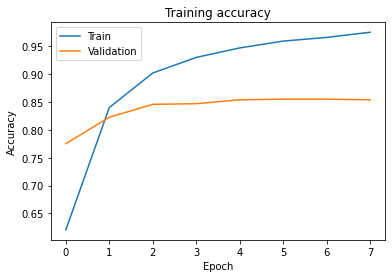

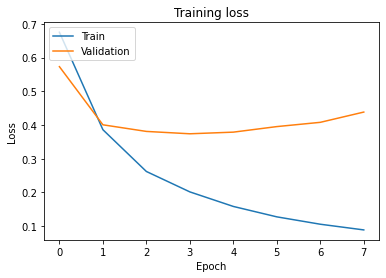

Model statistics with class predictions: 
Accuracy: 0.8691
Precision: 0.8648
Recall: 0.8749
F1 score: 0.8698
Confusion matrix:
               pred:positive  pred:negative
true:positive            745            118
true:negative            108            755


In [17]:
embedding_layer = Embedding(input_dim, output_dim, trainable = True)
model = create_model(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'cnnlstm-nowv-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'cnnlstm-nowv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [18]:
# Save best performing model (weights, architecture)
model.save('../../models/models/cnnlstm-nowv')

INFO:tensorflow:Assets written to: ../../models/models/cnnlstm-nowv\assets


INFO:tensorflow:Assets written to: ../../models/models/cnnlstm-nowv\assets


Cross-validation with pretrained word vectors

In [19]:
results = run_test(create_model, Xtrain_concat, ytrain_concat, 'wv')
print('Average model accuracy of cross validation without word vectors: %.4f' % results.mean())
print('Standard deviation of the accuracy: %.4f' % np.std(results))
print('The best model accuracy of cross validation without word vectors: %.4f' % results.max())

Accuracy for iteration 0: 0.8814
Accuracy for iteration 1: 0.8640
Accuracy for iteration 2: 0.8722
Average model accuracy of cross validation without word vectors: 0.8725
Standard deviation of the accuracy: 0.0071
The best model accuracy of cross validation without word vectors: 0.8814


Evaluation with pretrained word vectors

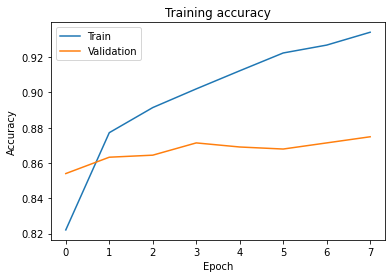

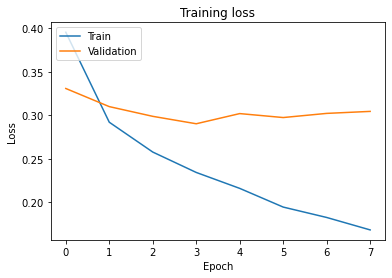

Model statistics with class predictions: 
Accuracy: 0.8824
Precision: 0.8675
Recall: 0.9027
F1 score: 0.8847
Confusion matrix:
               pred:positive  pred:negative
true:positive            744            119
true:negative             84            779


In [20]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=emdedding_size, embeddings_initializer=tf.keras.initializers.Constant(vectors), trainable=False)
model = create_model(embedding_layer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'cnnlstm-wv-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'cnnlstm-wv-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [21]:
model.save('../../models/models/cnnlstm-wv')

INFO:tensorflow:Assets written to: ../../models/models/cnnlstm-wv\assets


INFO:tensorflow:Assets written to: ../../models/models/cnnlstm-wv\assets


# Model evaluation on IMDB dataset

In [22]:
# IMDB dataset
from keras.datasets import imdb
word_count = 5000
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=word_count)
max_length = 500
X_train_imdb = sequence.pad_sequences(X_train_imdb, maxlen=max_length)
X_test_imdb = sequence.pad_sequences(X_test_imdb, maxlen=max_length)

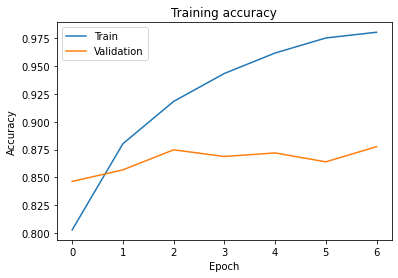

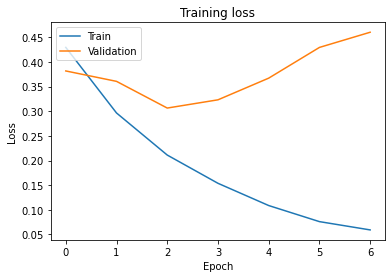

Model statistics with class predictions: 
Accuracy: 0.8639
Precision: 0.9061
Recall: 0.8120
F1 score: 0.8565
Confusion matrix:
               pred:positive  pred:negative
true:positive          11448           1052
true:negative           2350          10150


In [23]:
embedding_layer = Embedding(word_count, 32, input_length=max_length)
model = model_2(embedding_layer)
Xtrain_imdb, Xval_imdb, ytrain_imdb, yval_imdb = train_test_split(X_train_imdb, y_train_imdb, random_state=seed, test_size=0.1, stratify=y_train_imdb, shuffle=True)
history = model.fit(Xtrain_imdb, ytrain_imdb, validation_data=(Xval_imdb, yval_imdb), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
# Accuracy
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy', 'imdb_cnnlstm-acc.pdf') 
# Loss
plot_history([history.history], 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss', 'imdb_cnnlstm-loss.pdf')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test_imdb, y_test_imdb)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)